In [ ]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [ ]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

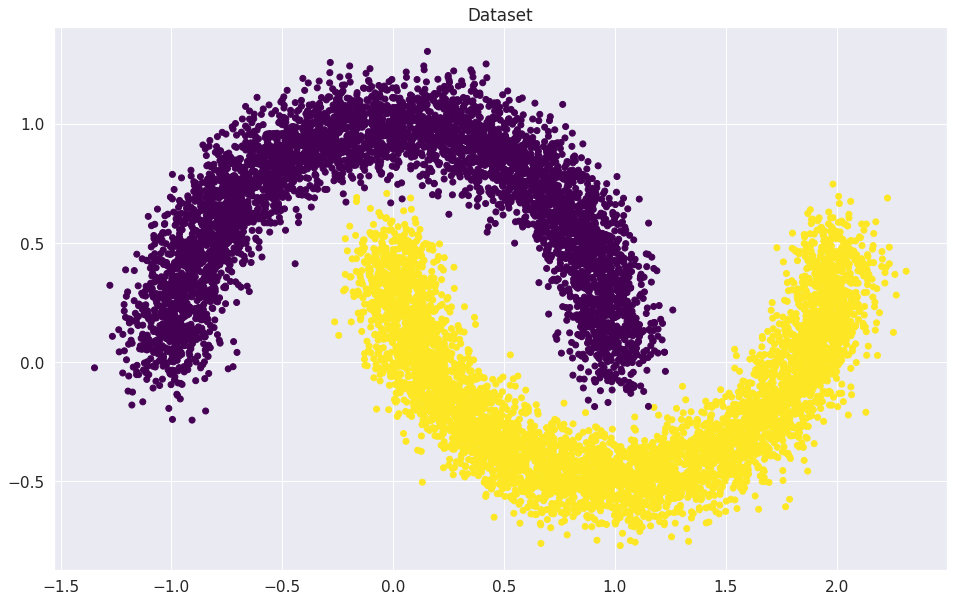

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)
X_train.shape, y_val.shape

((7500, 2), (2500,))

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [ ]:
X_train_t = torch.as_tensor(X_train, dtype=torch.float) # YOUR CODE GOES HERE
y_train_t = torch.FloatTensor(y_train) # YOUR CODE GOES HERE
X_val_t = torch.as_tensor(X_val, dtype=torch.float)     # YOUR CODE GOES HERE
y_val_t = torch.FloatTensor(y_val)     # YOUR CODE GOES HERE

Создаем `Dataset` и `DataLoader`. 

In [ ]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [ ]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, 1)) # YOUR CODE GOES HERE
        self.bias = bias
        if bias:
            self.bias_term = torch.nn.Parameter(torch.ones(out_features)) # YOUR CODE GOES HERE

    def forward(self, x):
      
        x = x @ self.weights # YOUR CODE GOES HERE
        if self.bias:
            x += self.bias_term # YOUR CODE GOES HERE
        return x

In [ ]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели?

In [ ]:
3 #YOUR CODE

3

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [ ]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression.forward(X_batch) # YOUR CODE. Use linear_regression to get outputs
        loss = loss_function(outp.squeeze(), y_batch) # YOUR CODE. Compute loss
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = torch.sigmoid(outp) # YOUR CODE. Compute probabilities
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.328125
Iteration: 100
Batch accuracy: 0.8515625
Iteration: 200
Batch accuracy: 0.875
Iteration: 300
Batch accuracy: 0.9140625
Iteration: 400
Batch accuracy: 0.8984375
Iteration: 500
Batch accuracy: 0.9140625
Iteration: 600
Batch accuracy: 0.875

Iteration: 696.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 696

### Визуализируем результаты

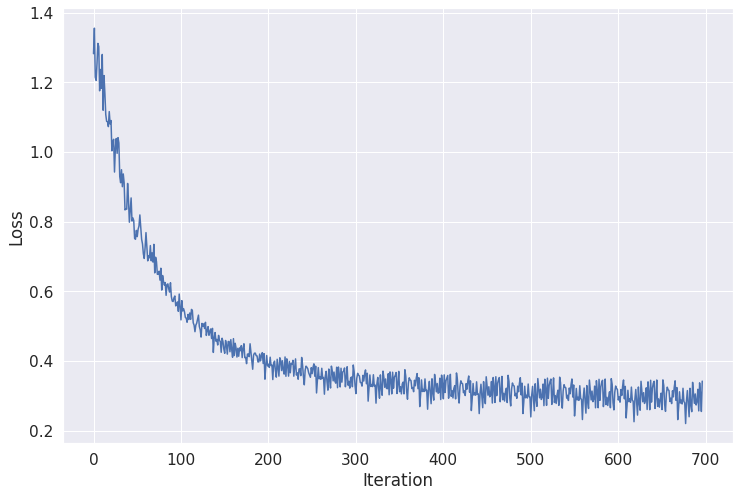

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

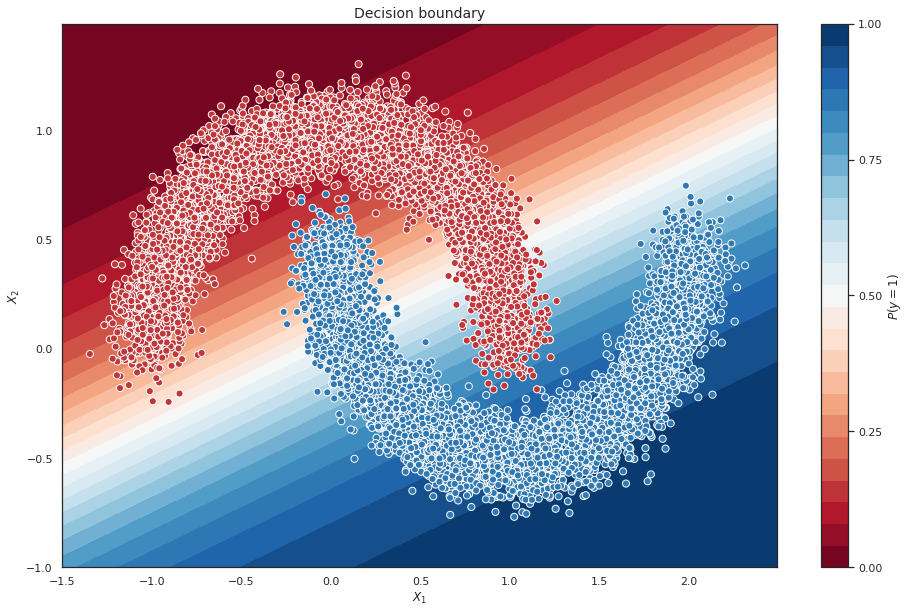

In [ ]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [ ]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        preds = (torch.sigmoid(model.forward(x_batch)) > 0.5).type(torch.long) #YOUR CODE. Compute predictions
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(y_val, predict(val_dataloader, linear_regression)) # YOUR CODE. Compute total accuracy

0.8752

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 0.8752

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [ ]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader = DataLoader(train_dataset, batch_size=64,shuffle=True, num_workers=2) # YOUR CODE GOES HERE
valid_dataloader = DataLoader(val_dataset, batch_size=64,shuffle=False, num_workers=2) # YOUR CODE GOES HERE

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [ ]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [ ]:
activation = nn.ELU

model = nn.Sequential(
    nn.Flatten(), nn.Linear(784, 128), activation(), nn.Linear(128, 128), activation(), nn.Linear(128, 10) 
    #YOUR CODE. Add layers to your sequential class
)

In [ ]:
criterion = nn.CrossEntropyLoss()   #YOUR CODE. Select a loss function
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [ ]:
def learning(model, optimizer):
    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    out = model(x_batch)  # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                else:
                    model.eval()
                    with torch.no_grad():
                      out = model(x_batch) # YOUR CODE. Set model to ``eval`` mode and calculate outputs
                preds = out.argmax(-1)
                correct = torch.sum((preds == y_batch)) # YOUR CODE GOES HERE
                all = y_batch.size(0) # YOUR CODE GOES HERE
                #print(correct, (preds.flatten() == y_batch).sum())
                epoch_correct += correct.item()
                epoch_all += all
                if k == "train":
                    loss = criterion(out, y_batch)
                    loss.backward()
                    optimizer.step() # YOUR CODE. Calculate gradients and make a step of your optimizer
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)
    return accuracy["valid"]


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [ ]:
elu_accuracy = learning(model, optimizer)

Epoch: 1
Loader: train. Accuracy: 0.9011166666666667
Loader: valid. Accuracy: 0.9489
Epoch: 2
Loader: train. Accuracy: 0.9550166666666666
Loader: valid. Accuracy: 0.9655
Epoch: 3
Loader: train. Accuracy: 0.96715
Loader: valid. Accuracy: 0.9663
Epoch: 4
Loader: train. Accuracy: 0.9729333333333333
Loader: valid. Accuracy: 0.9641
Epoch: 5
Loader: train. Accuracy: 0.9770333333333333
Loader: valid. Accuracy: 0.9679
Epoch: 6
Loader: train. Accuracy: 0.9805333333333334
Loader: valid. Accuracy: 0.9715
Epoch: 7
Loader: train. Accuracy: 0.9824833333333334
Loader: valid. Accuracy: 0.9701
Epoch: 8
Loader: train. Accuracy: 0.9845666666666667
Loader: valid. Accuracy: 0.9713
Epoch: 9
Loader: train. Accuracy: 0.98555
Loader: valid. Accuracy: 0.9751
Epoch: 10
Loader: train. Accuracy: 0.9860333333333333
Loader: valid. Accuracy: 0.9699


In [ ]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)

def test_activation_function(activation):
    print('Функция активации: ', activation)
    model = nn.Sequential(
    nn.Flatten(), nn.Linear(784, 128), activation(), nn.Linear(128, 128), activation(), nn.Linear(128, 10) 
    )
    optimizer = torch.optim.Adam(model.parameters())
    return learning(model, optimizer)
    #YOUR CODE

In [ ]:
plain_accuracy = test_activation_function(Identical)
relu_accuracy = test_activation_function(nn.ReLU)       #YOUR CODE
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU) #YOUR CODE

Функция активации:  <class '__main__.Identical'>
Epoch: 1
Loader: train. Accuracy: 0.87475
Loader: valid. Accuracy: 0.9081
Epoch: 2
Loader: train. Accuracy: 0.8995
Loader: valid. Accuracy: 0.8841
Epoch: 3
Loader: train. Accuracy: 0.9044
Loader: valid. Accuracy: 0.8999
Epoch: 4
Loader: train. Accuracy: 0.9076833333333333
Loader: valid. Accuracy: 0.9113
Epoch: 5
Loader: train. Accuracy: 0.9069
Loader: valid. Accuracy: 0.9088
Epoch: 6
Loader: train. Accuracy: 0.9088166666666667
Loader: valid. Accuracy: 0.9173
Epoch: 7
Loader: train. Accuracy: 0.9111166666666667
Loader: valid. Accuracy: 0.9148
Epoch: 8
Loader: train. Accuracy: 0.9120833333333334
Loader: valid. Accuracy: 0.9076
Epoch: 9
Loader: train. Accuracy: 0.9138333333333334
Loader: valid. Accuracy: 0.9084
Epoch: 10
Loader: train. Accuracy: 0.9144
Loader: valid. Accuracy: 0.9159
Функция активации:  <class 'torch.nn.modules.activation.ReLU'>
Epoch: 1
Loader: train. Accuracy: 0.8894666666666666
Loader: valid. Accuracy: 0.9324
Epoch: 2
Lo

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

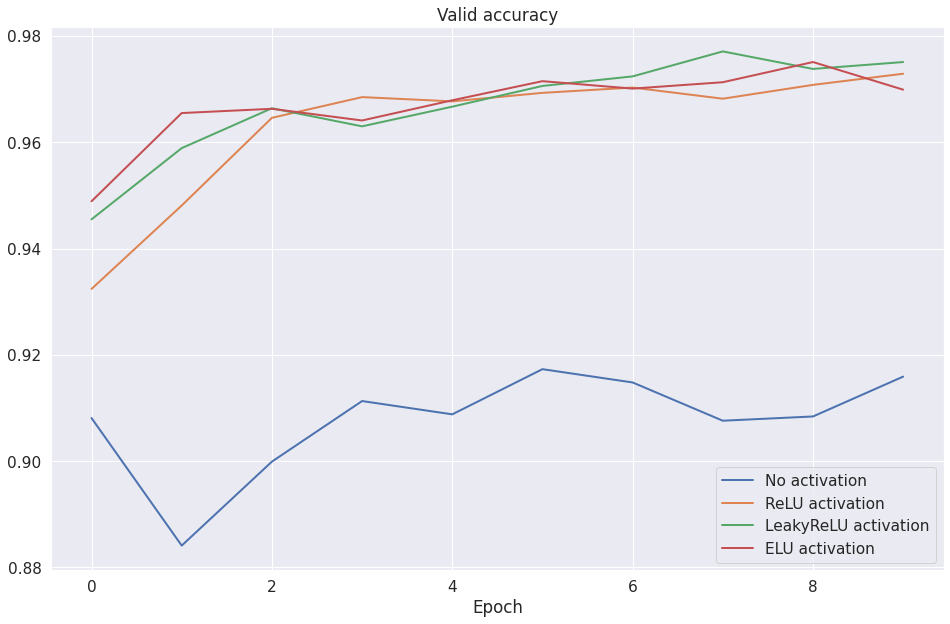

In [ ]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(10), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(10), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(10), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(10), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

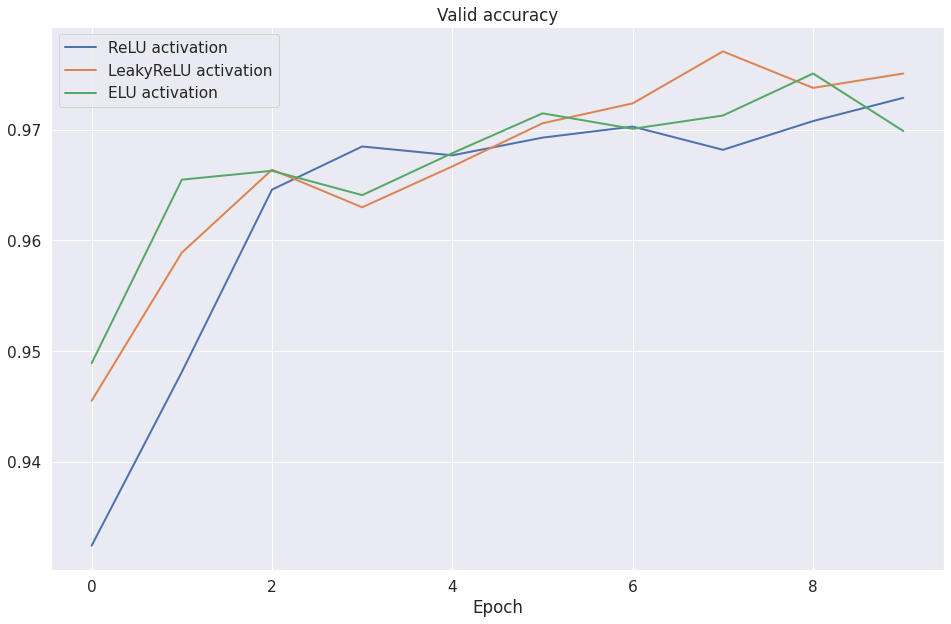

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(10), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(10), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(10), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** LeakyReLU

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработаем с самим понятием ядра свёртки.

In [ ]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2021-11-15 18:26:34--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 144.76.208.75
Connecting to img.the-village.kz (img.the-village.kz)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg [following]
--2021-11-15 18:26:35--  https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village-kz.com (img.the-village-kz.com)... 144.76.208.75
Connecting to img.the-village-kz.com (img.the-village-kz.com)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K   110KB/s    in 0.4s    

2021-11-15 18:26:36 (110 KB/s) - ‘sample_photo.jpg’ saved [49337/4

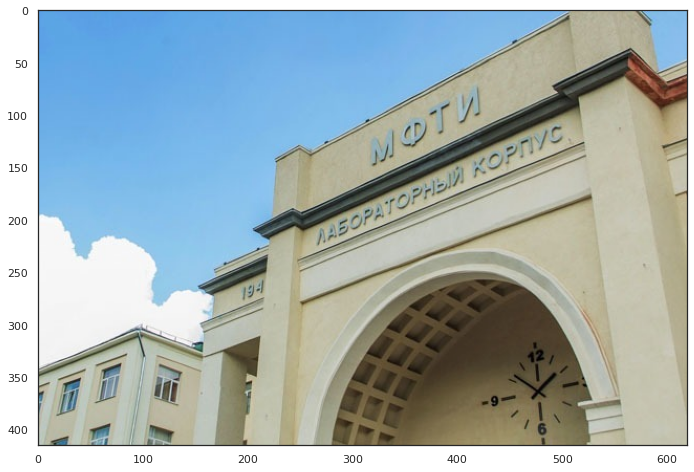

In [ ]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 

A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [ ]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size
kernel, result = [], []


kernel.append(torch.tensor([
    [0, 0, 0],
    [0, 1, 0],
    [0, 0, 0]
]).reshape(1, 1, 3, 3).type(torch.float32))
kernel.append(torch.tensor([
    [0, 1, 0],
    [0, -2, 0],
    [0, 1, 0]
]).reshape(1, 1, 3, 3).type(torch.float32))
kernel.append(torch.tensor([
    [0, 0, 0],
    [1, -2, 1],
    [0, 0, 0]
]).reshape(1, 1, 3, 3).type(torch.float32))
kernel.append(torch.tensor([
    [0, 1, 0],
    [1, -4, 1],
    [0, 1, 0]
]).reshape(1, 1, 3, 3).type(torch.float32))
kernel.append(torch.tensor([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
]).reshape(1, 1, 3, 3).type(torch.float32))
kernel.append(torch.tensor([
    [0.0625, 0.125, 0.0625],
    [0.125, 0.25, 0.125],
    [0.0625, 0.125, 0.0625]
]).reshape(1, 1, 3, 3).type(torch.float32))

for i in range(6):
  kernel[i] = kernel[i].repeat(3, 3, 1, 1)
  result.append(F.conv2d(img_t, kernel[i])[0])  #

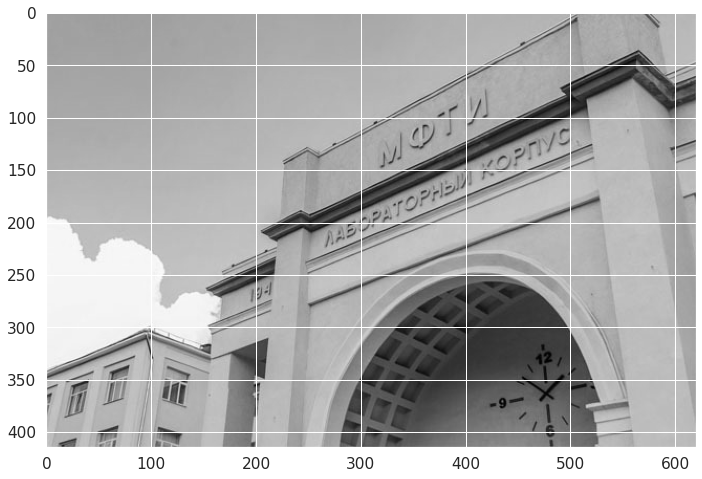

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


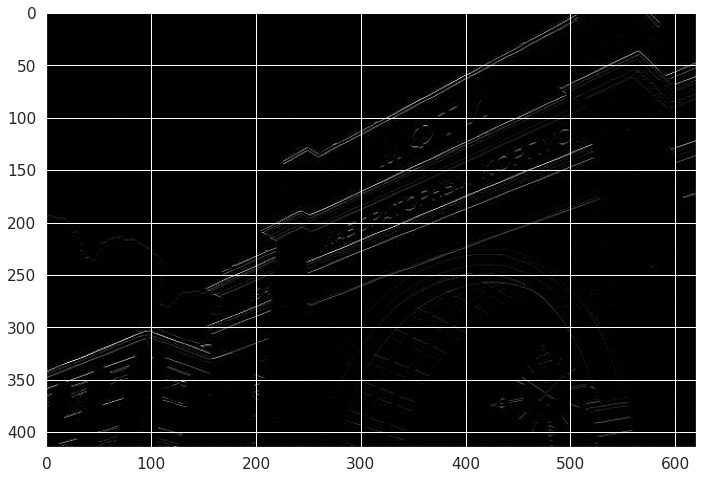

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


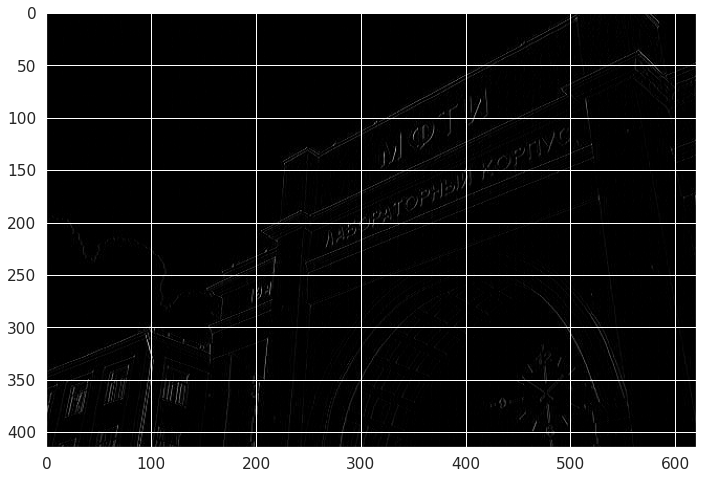

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


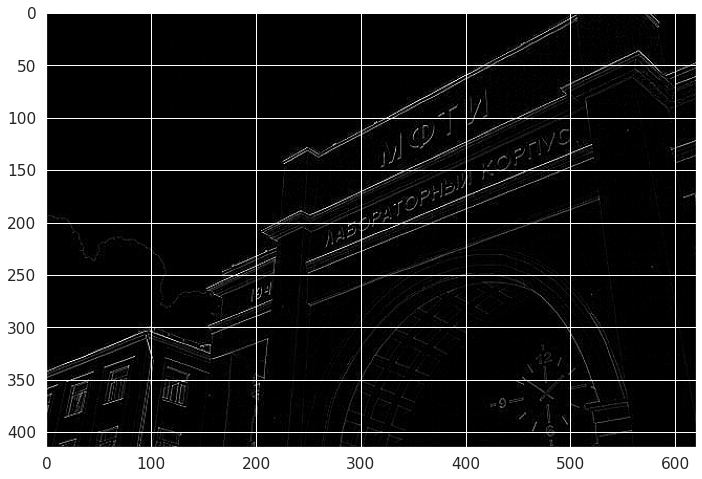

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


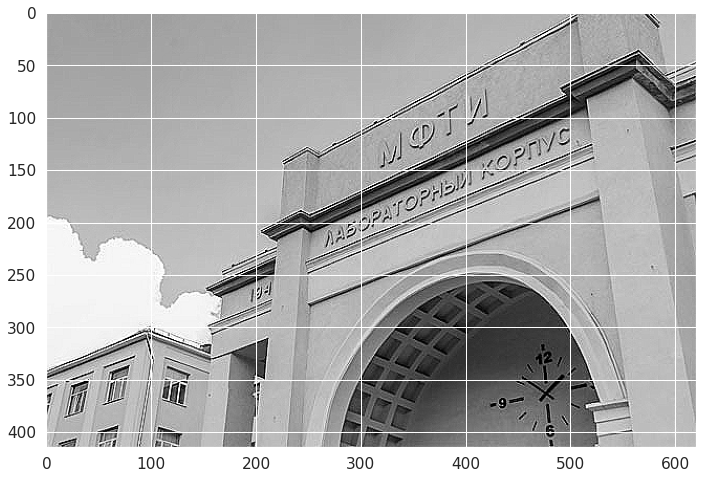

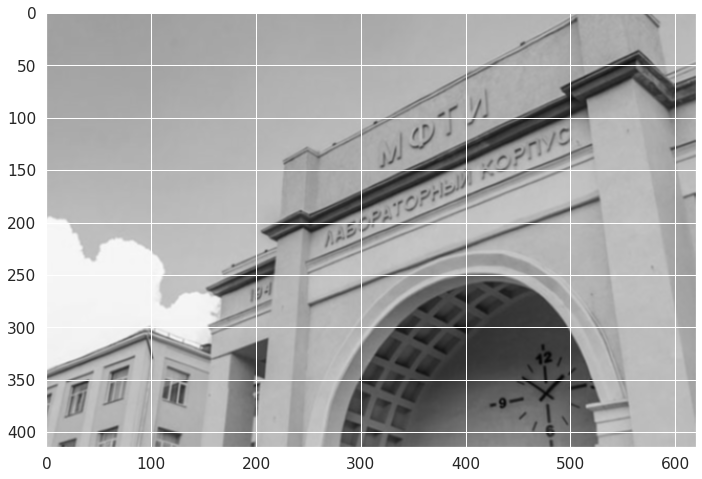

In [ ]:
for i in range(6):
  plt.figure(figsize=(12, 8))
  result_np = result[i].permute(1, 2, 0).numpy() / 256 / 3
  plt.imshow(result_np)
  plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:** 
A - 3
Б - 5
В - 4
Г - 6
Д - 2
Е - 1

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(kernel_size = 2) #YOUR CODE
        self.conv2 = nn.Conv2d(6, 16, 3) #YOUR CODE
        self.pool2 = nn.MaxPool2d(kernel_size = 2) #YOUR CODE
        self.fc1 = nn.Linear(5 * 5 * 16, 120) #YOUR CODE 
        self.ac1 = nn.ReLU() 
        self.fc2 = nn.Linear(120, 84) #YOUR CODE
        self.ac2 = nn.ReLU() 
        self.fc3 = nn.Linear(84, 10) #YOUR CODE

    def forward(self, x):
        x = self.conv1(x) #YOUR CODE. Apply layers created in __init__. 
        x = self.ac1(x)
        x = self.pool1(x)
        x = self.conv2(x) 
        x = self.ac1(x)
        x = self.pool2(x)
        x = x.view(-1, 5 * 5 * 16)
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        x = self.fc3(x)
        return x

In [ ]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [ ]:
# Для удобства перенес функцию сюда, т.к. нужно добавить .to(device) к батчем

def learning1(model):
    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    out = model(x_batch.to(device))  # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                else:
                    model.eval()
                    with torch.no_grad():
                      out = model(x_batch.to(device)) # YOUR CODE. Set model to ``eval`` mode and calculate outputs
                preds = out.argmax(-1)
                correct = torch.sum((preds.cpu().detach() == y_batch)) # YOUR CODE GOES HERE
                all = y_batch.size(0) # YOUR CODE GOES HERE
                epoch_correct += correct.item()
                epoch_all += all
                if k == "train":
                    loss = criterion(out, y_batch.to(device))
                    loss.backward()
                    optimizer.step() # YOUR CODE. Calculate gradients and make a step of your optimizer
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)
    return accuracy["valid"]


In [ ]:
lenet_accuracy = learning1(model)

Epoch: 1
Loader: train. Accuracy: 0.9150666666666667
Loader: valid. Accuracy: 0.9724
Epoch: 2
Loader: train. Accuracy: 0.9768
Loader: valid. Accuracy: 0.983
Epoch: 3
Loader: train. Accuracy: 0.9840666666666666
Loader: valid. Accuracy: 0.9856
Epoch: 4
Loader: train. Accuracy: 0.9873
Loader: valid. Accuracy: 0.9875
Epoch: 5
Loader: train. Accuracy: 0.9892
Loader: valid. Accuracy: 0.9866
Epoch: 6
Loader: train. Accuracy: 0.9918166666666667
Loader: valid. Accuracy: 0.9866
Epoch: 7
Loader: train. Accuracy: 0.9921333333333333
Loader: valid. Accuracy: 0.9899
Epoch: 8
Loader: train. Accuracy: 0.9936333333333334
Loader: valid. Accuracy: 0.988
Epoch: 9
Loader: train. Accuracy: 0.9938666666666667
Loader: valid. Accuracy: 0.9877
Epoch: 10
Loader: train. Accuracy: 0.9948333333333333
Loader: valid. Accuracy: 0.9855


Сравним с предыдущем пунктом

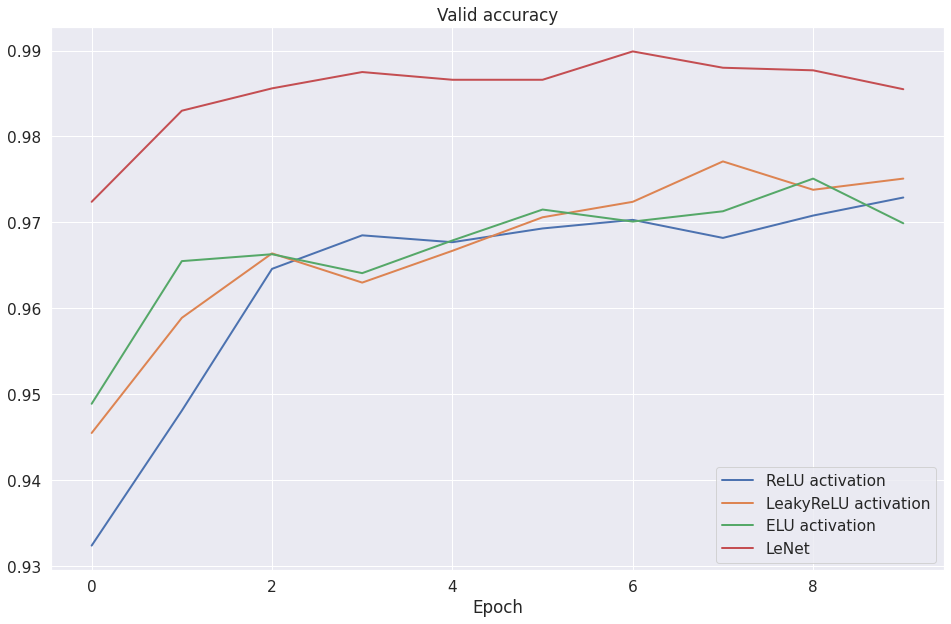

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(10), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(10), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(10), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(10), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

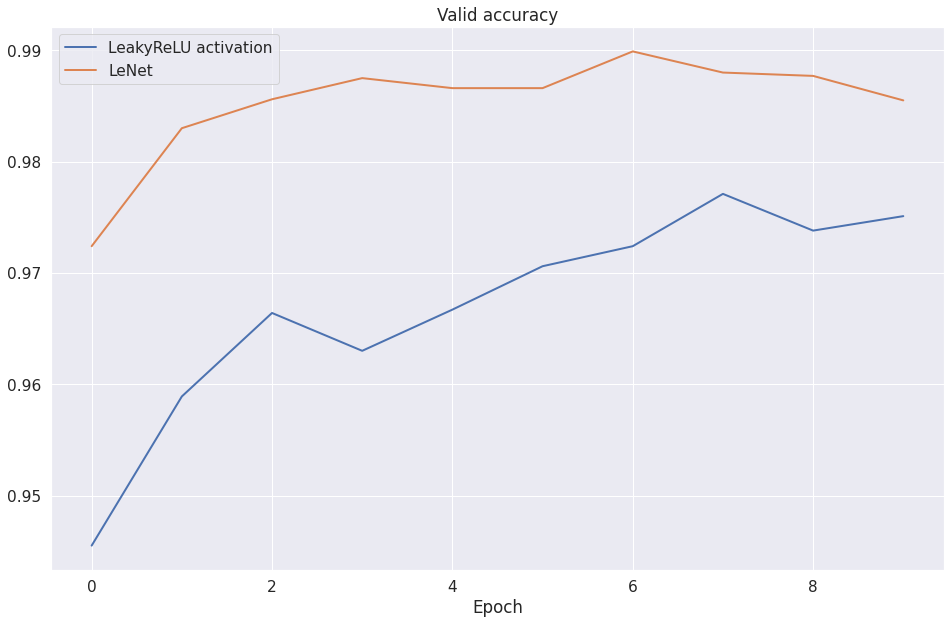

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(10), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(10), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [ ]:
max(lenet_accuracy) 

0.9899

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0,99